(astrometric)=

# Astrometric fitting

In this case study we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Setup

In [1]:
import jax
import numpyro

# For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_host_device_count(2)

# For CPU (use "gpu" for GPU)
numpyro.set_platform("cpu")

# For 64-bit precision since JAX defaults to 32-bit
jax.config.update("jax_enable_x64", True)

/Users/lionelgarcia/code/jaxoplanet-case-studies/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract).

In [2]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

/Users/lionelgarcia/code/jaxoplanet-case-studies/.venv/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 6 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/lionelgarcia/code/jaxoplanet-case-studies/.venv/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 5 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/lionelgarcia/code/jaxoplanet-case-studies/.venv/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 5 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/lionelgarcia/code/jaxoplanet-case-studies/.venv/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 6 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/lionelgarcia/code/jaxoplane

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [3]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit.

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

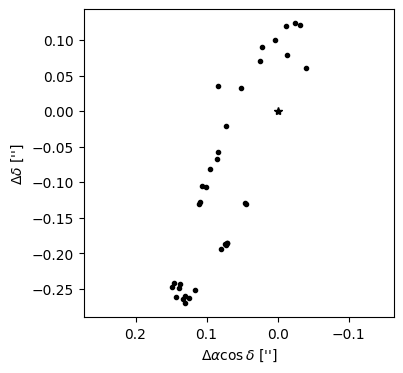

In [4]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

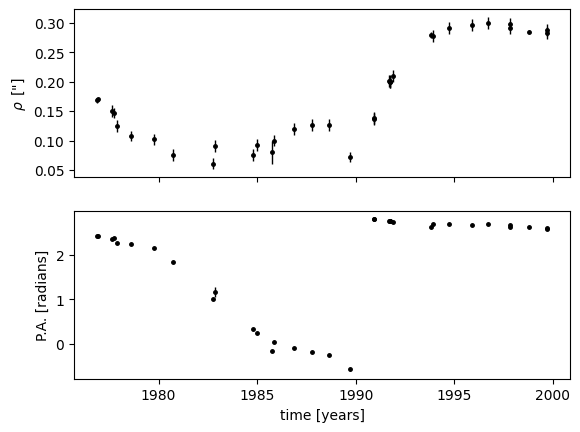

In [5]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

## Data model

We will now fit the these astrometric data using [numpyro]() and jaxoplanet.

We first define the parameters of our model as found in the litterature

<!-- To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample. -->

In [6]:
import numpy as np
from jaxoplanet.units import unit_registry as ureg

au = (1 * ureg.au).to("R_sun").magnitude

litt_params = {
    "a_ang": 0.324,  # arcsec
    "parallax": 1.0,  # arcsec (meaningless choice for now)
    "ecc": 0.798,
    "inc": np.deg2rad(96.0),  # [rad]
    "omega": np.deg2rad(251.6) - np.pi,  # Pourbaix reports omega_2, but we want omega_1
    "Omega": np.deg2rad(159.6),
    "period": 28.8 * 365.25,  # days
}

time_peri = Time(1989.92, format="decimalyear")
time_peri.format = "jd"
time_peri = time_peri.value  # [Julian Date]

litt_params["t0"] = time_peri
litt_params["a"] = litt_params["a_ang"] / litt_params["parallax"] * au

And we define our jaxoplanet model of the astrometric data

In [46]:
from jaxoplanet.orbits.keplerian import System, Central


def model_system(params):
    central = Central.from_orbital_properties(
        period=params["period"], semimajor=params["a"]
    )

    system = System(central).add_body(
        eccentricity=params["ecc"],
        inclination=params["inc"],
        omega_peri=params["omega"],
        asc_node=params["Omega"],
        period=params["period"],
        time_peri=params["t0"],
    )

    return system


def model_angles(params, time, parallax=None):
    system = model_system(params)
    body = system.bodies[0]
    rho, theta = body.relative_angles(time, parallax=1.0 if parallax is None else parallax)
    return rho.magnitude, theta.magnitude


time = np.linspace(
    time_peri - litt_params["period"], time_peri + litt_params["period"], 200
)

Let's plot up a preliminary orbit from the literature using this model

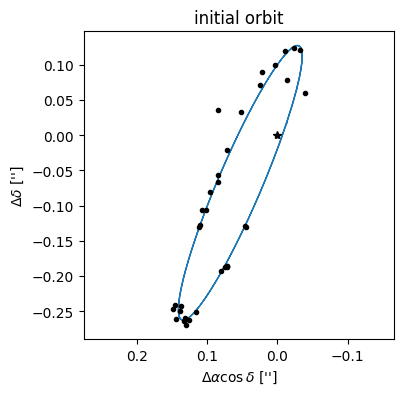

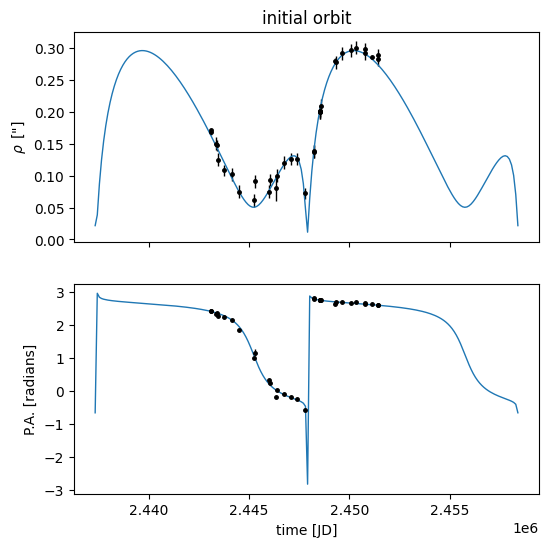

In [47]:
rho, theta = model_angles(litt_params, time)

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(time, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(time, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")

## NumPyro model

We can now define our NumPyro model containing the prior distributions of the parameters

In [95]:
import numpyro
import jax.numpy as jnp
import numpyro_ext as npx


def model(parallax=None):
    if parallax is None:
        # Without an actual parallax measurement, we can model the orbit in units of
        # arcseconds by providing a fake_parallax and conversion constant
        plx = 1  # arcsec
    else:
        # Below we will run a version of this model where a measurement of parallax is
        # provided. The measurement is in milliarcsec
        m_plx = numpyro.sample(
            "m_plx",
            numpyro.distributions.TruncatedDistribution(
                numpyro.distributions.Normal(*parallax), 0, 100
            ),
        )
        plx = numpyro.deterministic("plx", 1e-3 * m_plx)

    a_ang = numpyro.sample("a_ang", numpyro.distributions.Uniform(0.1, 1.0))
    a = numpyro.deterministic("a", a_ang / plx * au)

    # We expect the period to be somewhere in the range of 25 years,
    # so we'll set a broad prior on logP
    logP = numpyro.sample(
        "logP", numpyro.distributions.Normal(np.log(25 * 365.25), 10.0)
    )
    P = numpyro.deterministic("period", jnp.exp(logP))

    # For astrometric-only fits, it's generally better to fit in
    # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
    # directly
    p = numpyro.sample("p", npx.distributions.Angle())
    m = numpyro.sample("m", npx.distributions.Angle())
    omega = numpyro.deterministic("omega", p - m)
    Omega = numpyro.deterministic("Omega", p + m)

    # For these orbits, it can also be better to fit for a phase angle
    # (relative to a reference time) instead of the time of periastron
    # passage directly
    phase = numpyro.sample("phase", npx.distributions.Angle())
    tperi = numpyro.deterministic("t0", time_peri + P * phase / (2 * np.pi))

    # Geometric uniform prior on cos(incl)
    cos_incl = numpyro.sample("cos_inc", numpyro.distributions.Uniform(-1, 1))
    incl = numpyro.deterministic("inc", jnp.arccos(cos_incl))
    ecc = numpyro.sample("ecc", numpyro.distributions.Uniform(0.0, 1.0))

    params = {
        "a": a,
        "period": P,
        "ecc": ecc,
        "inc": incl,
        "omega": omega,
        "Omega": Omega,
        "t0": tperi,
    }

    # Compute the model in rho and theta
    rho_model, theta_model = model_angles(params, astro_jds, parallax=plx)
    numpyro.deterministic("rho_model", rho_model)
    numpyro.deterministic("theta_model", theta_model)

    # Add jitter terms to both separation and position angle
    log_rho_s = numpyro.sample(
        "log_rho_s", numpyro.distributions.Normal(np.log(np.median(rho_err)), 2.0)
    )
    log_theta_s = numpyro.sample(
        "log_theta_s", numpyro.distributions.Normal(np.log(np.median(theta_err)), 2.0)
    )
    rho_tot_err = jnp.sqrt(rho_err**2 + jnp.exp(2 * log_rho_s))
    theta_tot_err = jnp.sqrt(theta_err**2 + jnp.exp(2 * log_theta_s))

    # define the likelihood function, e.g., a Gaussian on both rho and theta
    numpyro.sample(
        "obs", numpyro.distributions.Normal(rho_model, rho_tot_err), obs=rho_data
    )

    # # We want to be cognizant of the fact that theta wraps so the following is equivalent to
    # # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
    # # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
    theta_diff = jnp.arctan2(
        jnp.sin(theta_model - theta_data), jnp.cos(theta_model - theta_data)
    )
    numpyro.sample(
        "theta_obs", numpyro.distributions.Normal(theta_diff, theta_tot_err), obs=0.0
    )

In [96]:
omega0 = np.deg2rad(251.6) - np.pi
Omega0 = np.deg2rad(159.6)

init_params = {
    "a_ang": 0.324,
    "logP": np.log(28.8 * 365.25),
    "p": 0.5 * (Omega0 + omega0),
    "m": 0.5 * (Omega0 - omega0),
    "cos_inc": np.cos(np.deg2rad(96.0)),
    "ecc": 0.798,
    "log_rho_s": np.log(np.median(rho_err)),
    "log_theta_s": np.log(np.median(theta_err)),
    "phase": 0.0,
    "parallax": 1.0,
}

opt_params = init_params.copy()

for sites in (
    ["phase" , "log_theta_s"],
    ["phase"],
    ["p", "m", "ecc"],
    ["logP", "a_ang", "phase"],
    None,
):
    print("Optimizing parameters:", sites if sites is not None else "all")
    run_optim = npx.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    )
    opt_params = run_optim(jax.random.PRNGKey(5))

opt_params = {**init_params, **opt_params}

Optimizing parameters: ['phase', 'log_theta_s']
Optimizing parameters: ['phase']
Optimizing parameters: ['p', 'm', 'ecc']
Optimizing parameters: ['logP', 'a_ang', 'phase']
Optimizing parameters: all


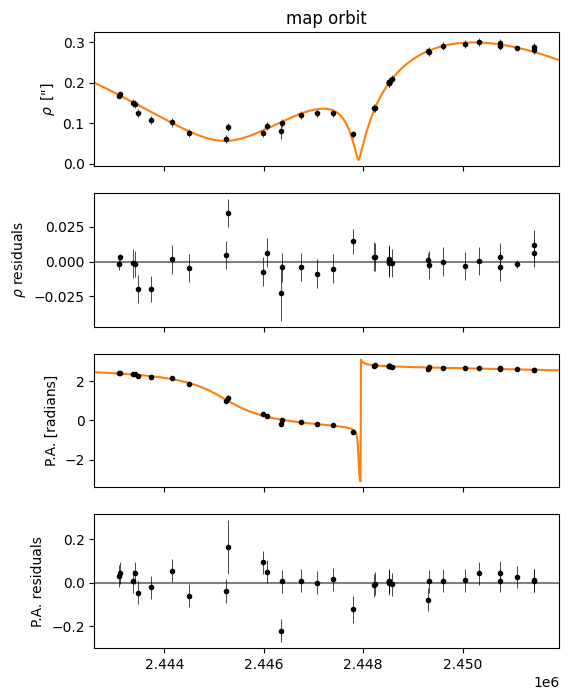

In [97]:
# our modeled data
oversamp_time = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, 1000)
model_rho, model_theta = model_angles(opt_params, oversamp_time)

ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * opt_params["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * opt_params["log_theta_s"]))


ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(oversamp_time, model_rho, "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, rho_data - opt_params["rho_model"], yerr=tot_rho_err, **ekw)


ax[2].plot(oversamp_time, model_theta, "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    astro_jds, theta_data - opt_params["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(oversamp_time[0], oversamp_time[-1])
_ = ax[0].set_title("map orbit")

Now let’s sample the posterior.

In [98]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        regularize_mass_matrix=False,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=1000,
    num_samples=4000,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(1))

sample: 100%|██████████| 5000/5000 [00:03<00:00, 1376.25it/s, 15 steps of size 3.14e-01. acc. prob=0.94]


First we can check the convergence for some of the key parameters.

In [99]:
sampler.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
        a_ang      0.32      0.01      0.32      0.31      0.33   3836.19      1.00
      cos_inc     -0.12      0.01     -0.12     -0.13     -0.11   4077.04      1.00
          ecc      0.78      0.01      0.78      0.76      0.80   3655.62      1.00
         logP      9.25      0.01      9.25      9.23      9.28   2649.13      1.00
    log_rho_s     -6.20      1.02     -5.93     -7.75     -4.73   1309.36      1.00
  log_theta_s     -2.94      0.15     -2.94     -3.18     -2.70   4342.34      1.00
            m      0.78      0.01      0.78      0.76      0.79   3809.35      1.00
            p      2.01      0.01      2.01      2.00      2.03   4146.69      1.00
        phase     -0.00      0.01     -0.00     -0.02      0.02   3448.65      1.00

Number of divergences: 0


That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

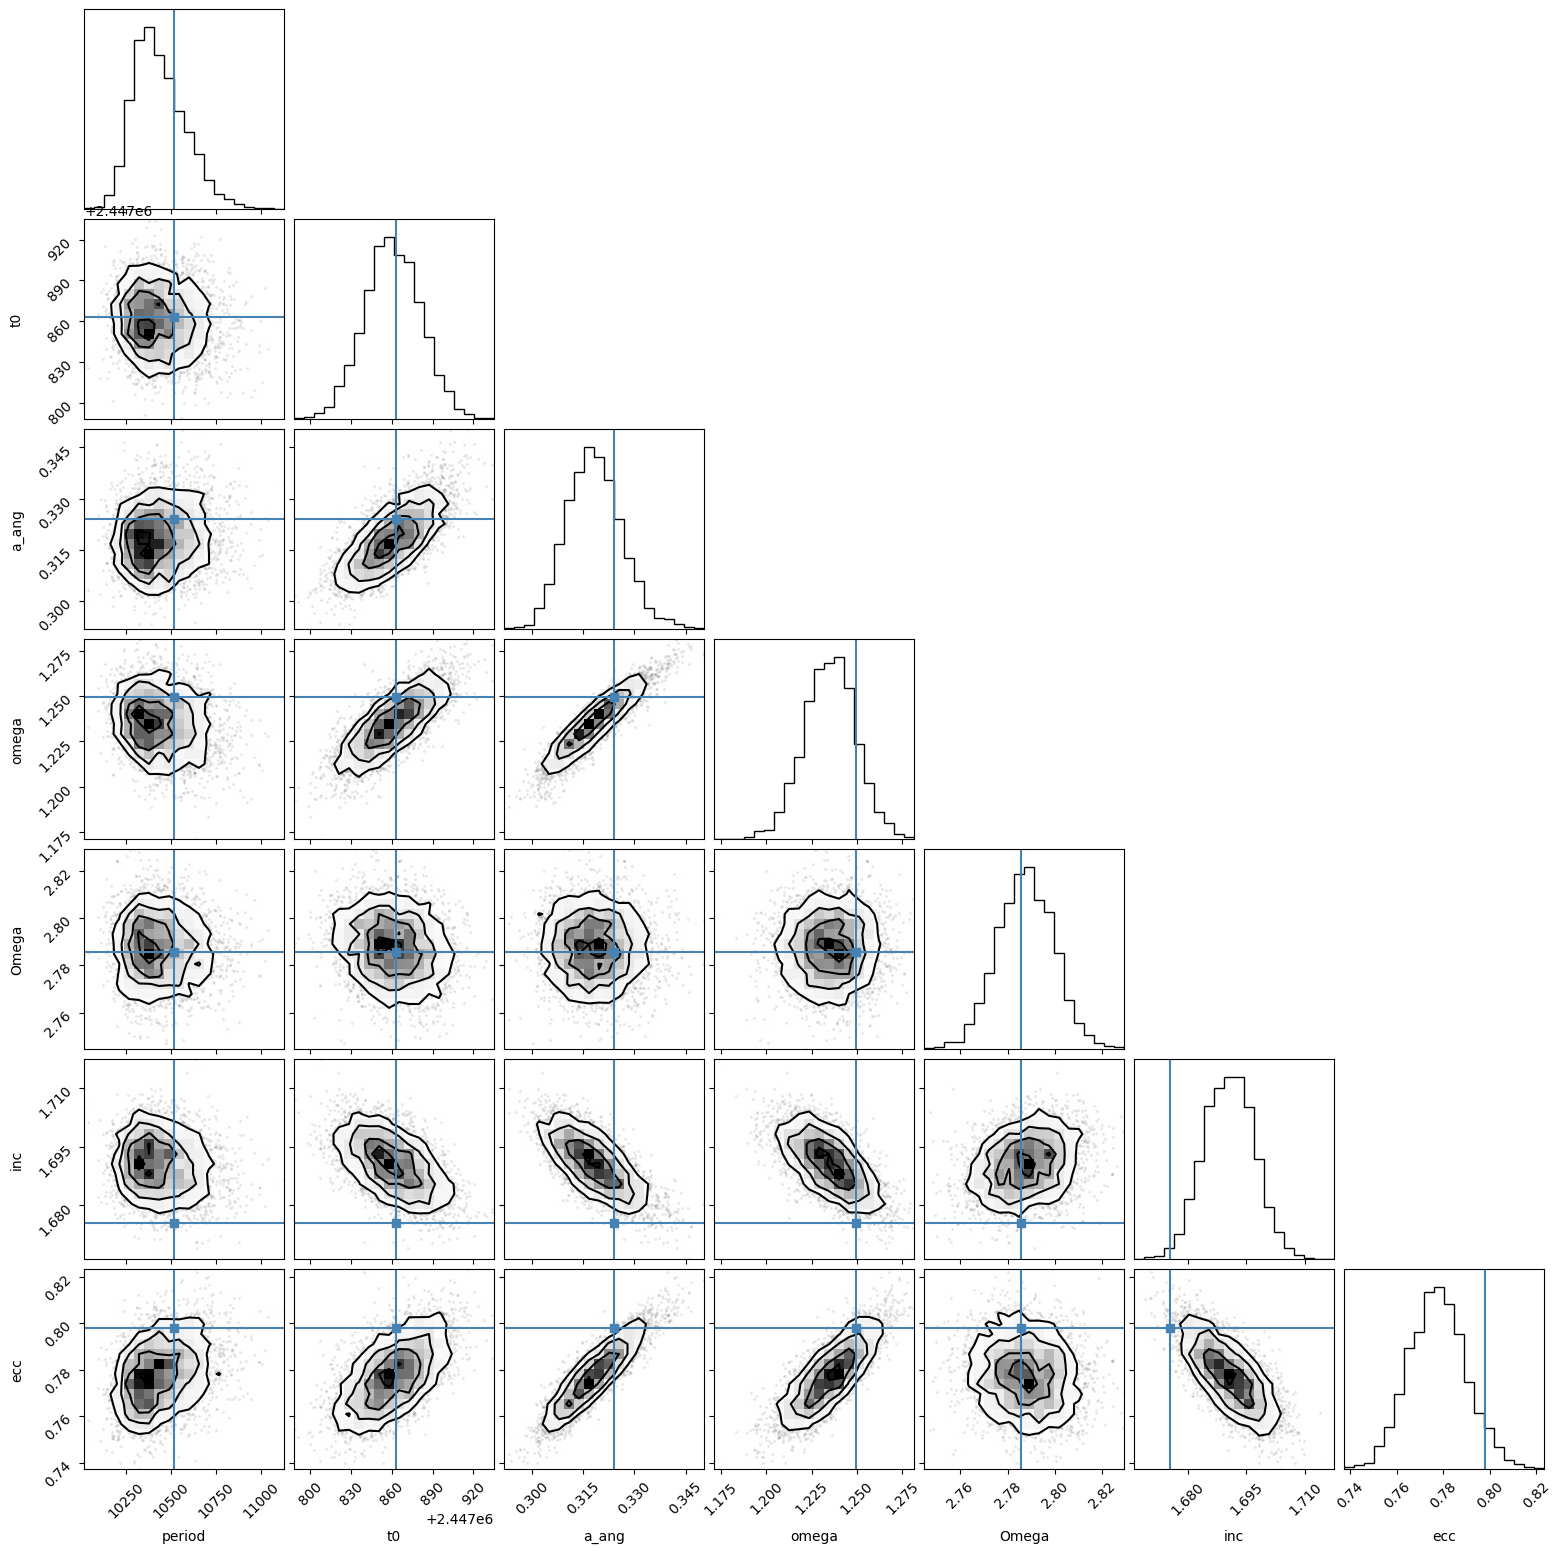

In [100]:
import corner
import arviz as az

inf_data = az.from_numpyro(sampler)

_ = corner.corner(
    inf_data,
    var_names=["period", "t0", "a_ang", "omega", "Omega", "inc", "ecc"],
    truths=[
        litt_params["period"],
        litt_params["t0"],
        litt_params["a_ang"],
        litt_params["omega"],
        litt_params["Omega"],
        litt_params["inc"],
        litt_params["ecc"],
    ],
)

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

In [101]:
model_params_names = [
    "period",
    "a",
    "ecc",
    "inc",
    "omega",
    "Omega",
    "period",
    "t0"
]

inferred_params = {key: inf_data.posterior.data_vars[key].values[0] for key in model_params_names}

In [102]:
rho_save, theta_save = jax.vmap(model_angles, in_axes=({key: 0 for key in model_params_names}, None))(
    inferred_params, oversamp_time
)

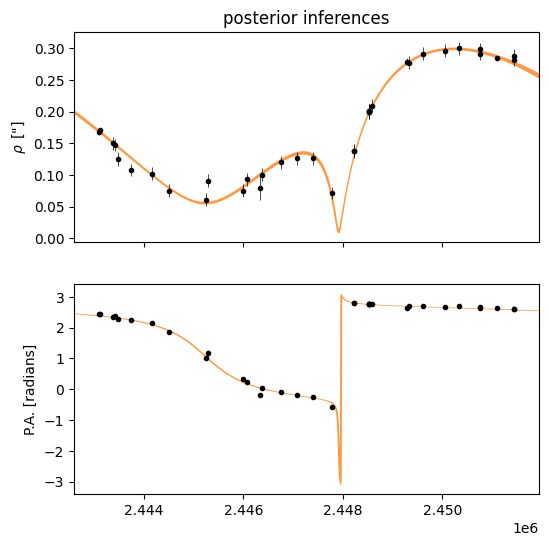

In [103]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(
    rho_err**2
    + np.exp(2 * np.median(inf_data.posterior["log_rho_s"].values, axis=(0, 1)))
)
tot_theta_err = np.sqrt(
    theta_err**2
    + np.exp(2 * np.median(inf_data.posterior["log_theta_s"].values, axis=(0, 1)))
)

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(rho_save, [16, 84], axis=(0))
ax[0].fill_between(oversamp_time, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(theta_save, [16, 84], axis=(0))
ax[1].fill_between(oversamp_time, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(oversamp_time[0], oversamp_time[-1])
_ = ax[0].set_title("posterior inferences")

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simplistic jitter model we implemented isn't sophisticated enough to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truly intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem.

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [93]:
for sites in (
    ["phase" , "log_theta_s"],
    ["phase"],
    ["p", "m", "ecc"],
    ["logP", "a_ang", "phase"],
    None,
):
    print("Optimizing parameters:", sites)
    run_optim = npx.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    )
    opt_params = run_optim(jax.random.PRNGKey(5))

opt_params = {**init_params, **opt_params}

Optimizing parameters: ['phase', 'log_theta_s']
Optimizing parameters: ['phase']
Optimizing parameters: ['p', 'm', 'ecc']
Optimizing parameters: ['logP', 'a_ang', 'phase']
Optimizing parameters: None


In [104]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        regularize_mass_matrix=False,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=1000,
    num_samples=4000,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(1), (24.5, 0.5))

sample: 100%|██████████| 5000/5000 [00:03<00:00, 1289.62it/s, 15 steps of size 3.43e-01. acc. prob=0.91]


Check the convergence diagnostics.

In [105]:
sampler.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
        a_ang      0.32      0.01      0.32      0.31      0.33   3196.06      1.00
      cos_inc     -0.12      0.01     -0.12     -0.13     -0.11   3770.28      1.00
          ecc      0.78      0.01      0.78      0.76      0.80   3290.38      1.00
         logP      9.25      0.01      9.25      9.23      9.27   2586.71      1.00
    log_rho_s     -6.21      1.00     -5.97     -7.71     -4.83   1386.19      1.00
  log_theta_s     -2.94      0.15     -2.94     -3.20     -2.70   3834.39      1.00
            m      0.78      0.01      0.78      0.76      0.79   3481.38      1.00
        m_plx     24.51      0.50     24.50     23.71     25.36   4525.53      1.00
            p      2.01      0.01      2.01      2.00      2.03   3533.17      1.00
        phase     -0.00      0.01     -0.00     -0.02      0.02   3465.40      1.00

Number of divergences: 1


And make the corner plot for the physical parameters.

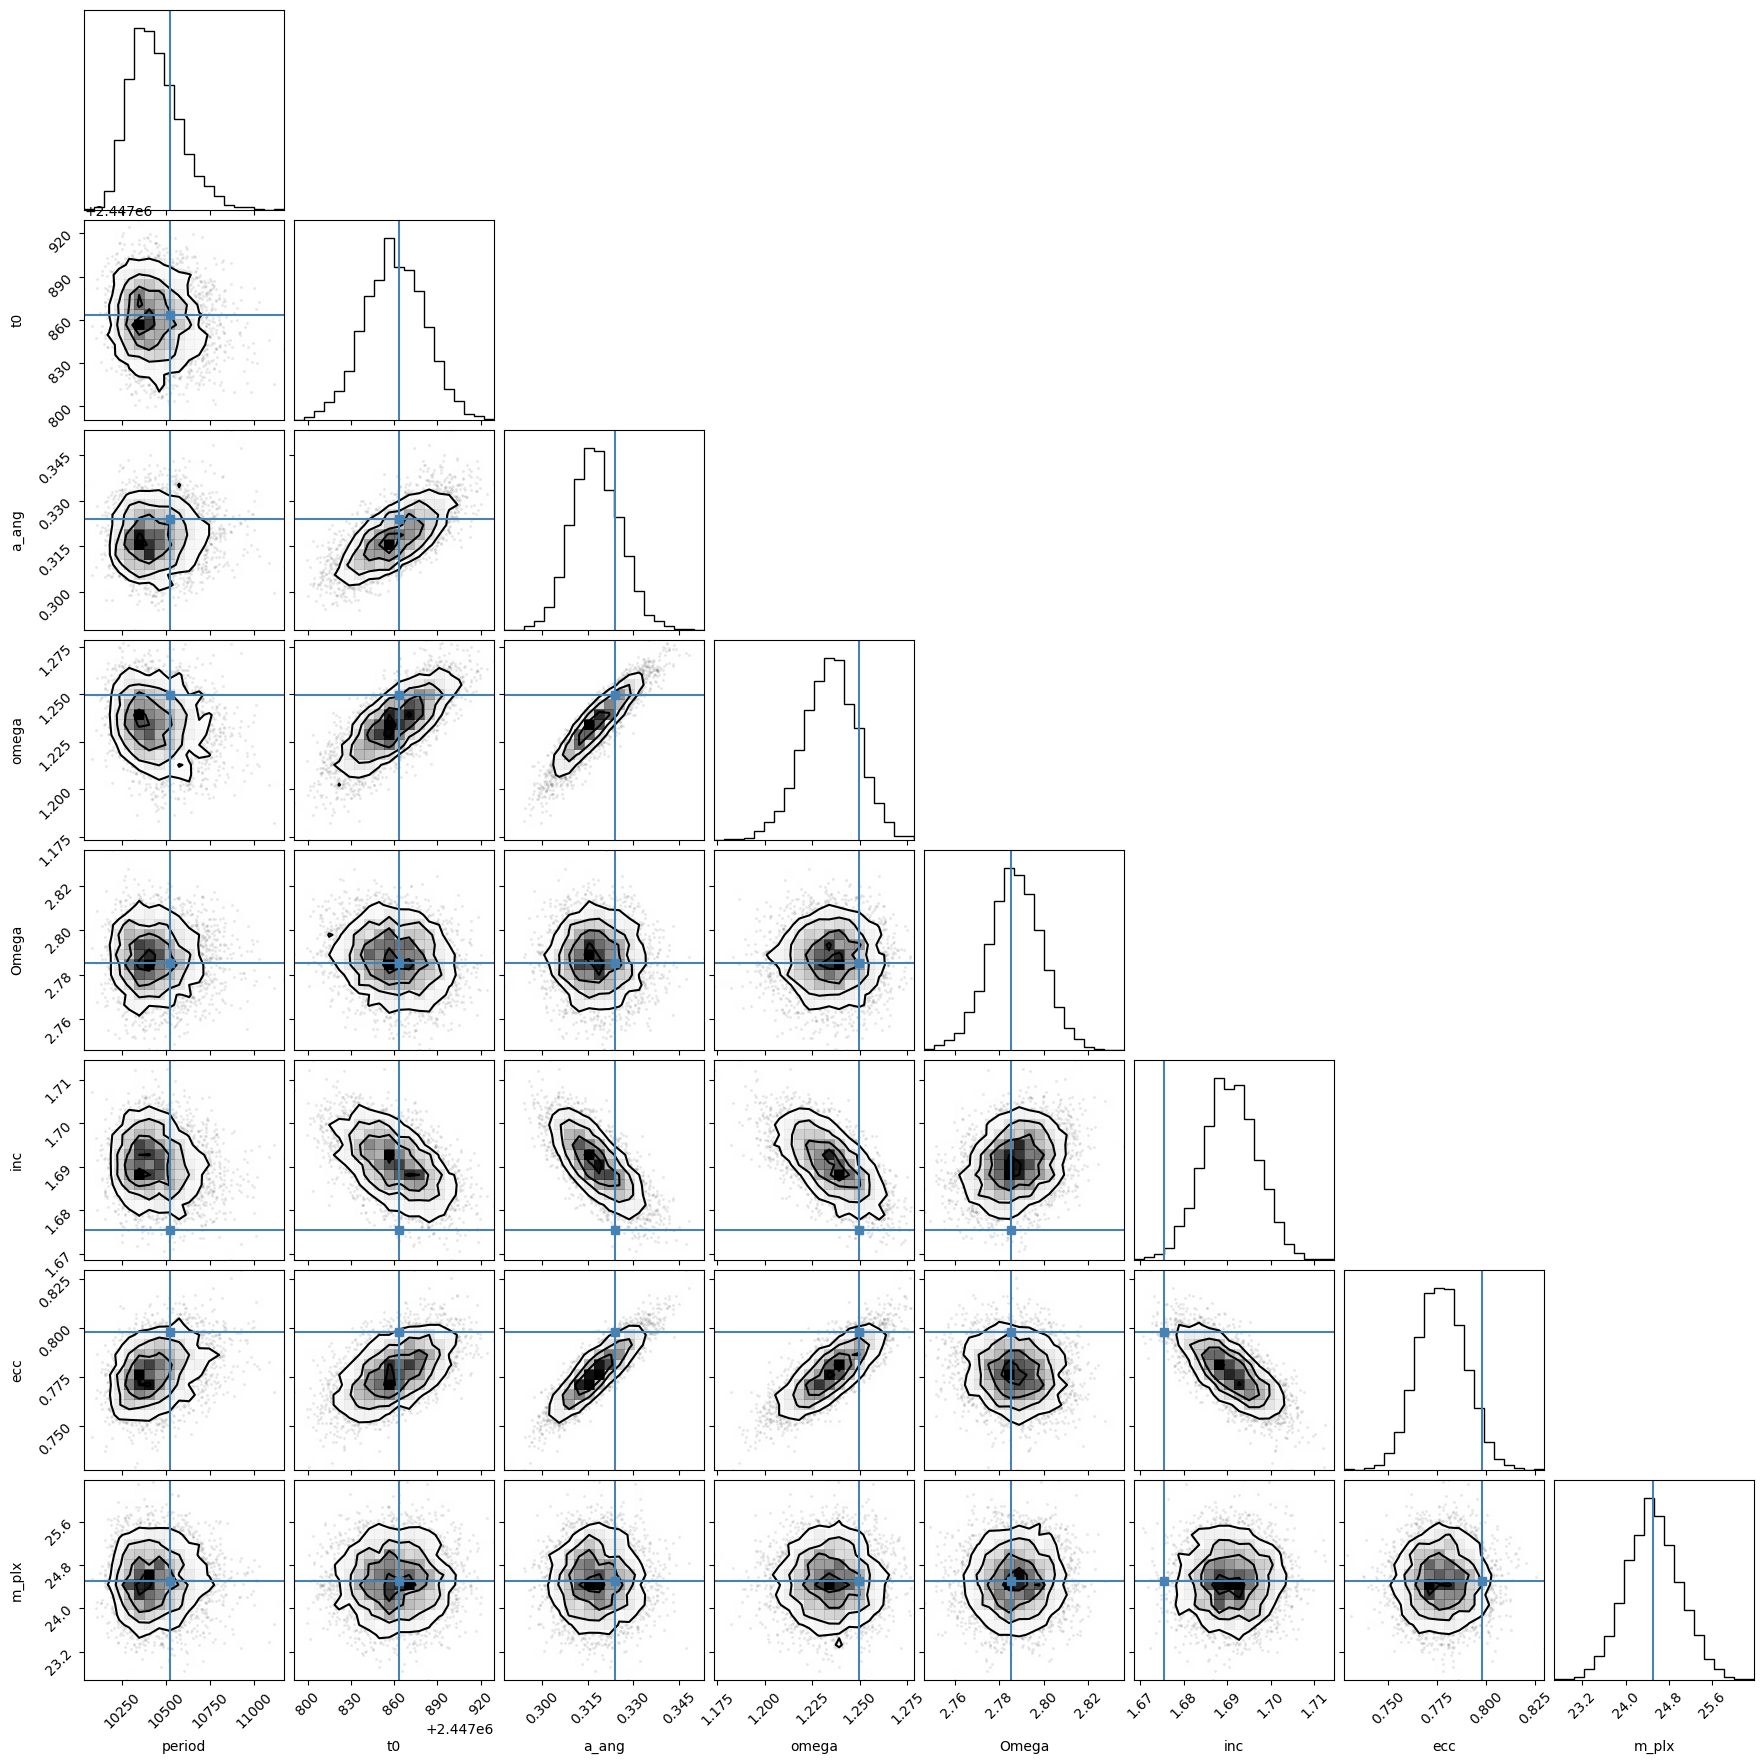

In [ ]:

inf_data = az.from_numpyro(sampler)

_ = corner.corner(
    inf_data,
    var_names=["period", "t0", "omega", "Omega", "inc", "ecc", "m_plx"],
    truths=[
        litt_params["period"],
        litt_params["t0"],
        litt_params["omega"],
        litt_params["Omega"],
        litt_params["inc"],
        litt_params["ecc"],
        24.5,
    ],
)